# Anomaly Detection using Autoencoder 2

Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# LuxTrace Dataset

In [ ]:
# Download the dataset
df = pd.read_csv('https://raw.githubusercontent.com/RegiMuhammar/luxtrace-machine-learning/main/Dataset/Dataset%20LuxTrace%20-%20Anomaly%20Delivery%20Detection.csv', delimiter=',', encoding='utf-8')
raw_data = df.values
df.head(10)

,delivery_id,product_name,delivery_product_amount,delivery_courier,delivery_store,delivery_distance,delivery_date,delivery_time,tracking_date,delivery_reception,delivery_duration,delivery_status,IsAnomaly
0,DL1,Atlas Sneaker White,119,Kevin Akbar,Depok-Cimanggis-16452,18000,1/1/2023,1/1/2023 17:21:06,1/1/2023 19:49:51,1/1/2023 19:49:51,8925,selesai,no
1,DL2,Atlas Sneaker White,117,Faisal Akbar,Jakarta-Kemang-12730,10000,1/1/2023,1/1/2023 16:34:55,1/1/2023 17:44:56,1/1/2023 17:44:56,4201,selesai,no
2,DL3,Atlas Sneaker White,143,Faisal Akbar,Depok-Cimanggis-16452,18000,1/1/2023,1/1/2023 10:50:55,1/1/2023 12:38:06,12/30/1899 0:00:00,6431,diperjalanan,no
3,DL4,Atlas Sneaker White,154,Putra Hadi,Jakarta-PasarMinggu-12520,15000,1/4/2023,1/4/2023 22:32:30,1/5/2023 0:53:00,1/5/2023 0:53:00,8430,selesai,no
4,DL5,Saki Sneakers - Soybean,121,Deni Setiawan,Jakarta-PasarMinggu-12520,15000,1/5/2023,1/5/2023 17:12:18,1/5/2023 19:30:03,1/5/2023 19:30:03,8265,selesai,no
5,DL6,Saki Sneakers - Soybean,136,Budi Hartono,Bogor-Baranangsiang-16143,30000,1/8/2023,1/8/2023 3:26:44,1/8/2023 4:49:17,12/30/1899 0:00:00,4953,diperjalanan,no
6,DL7,Saki Sneakers - Soybean,177,Kevin Akbar,Bekasi-BekasiTimur-17113,20000,1/8/2023,1/8/2023 17:05:27,1/8/2023 20:04:23,1/8/2023 20:04:23,10736,selesai,no
7,DL8,Saki Sneakers - Soybean,165,Citra Dewi,Bogor-Baranangsiang-16143,30000,1/8/2023,1/8/2023 11:54:52,1/8/2023 15:48:34,1/8/2023 15:48:34,14022,selesai,no
8,DL9,Kotta Hybrid Sneakers - Skeleton,136,Citra Dewi,Jakarta-Kemang-12730,10000,1/9/2023,1/9/2023 5:28:16,1/9/2023 6:51:23,1/9/2023 6:51:23,4987,selesai,no
9,DL10,Kotta Hybrid Sneakers - Skeleton,135,Kevin Akbar,Jakarta-Kemang-12730,10000,1/10/2023,1/10/2023 19:31:02,1/10/2023 20:46:21,1/10/2023 20:46:21,4519,selesai,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   delivery_id              500 non-null    object
 1   product_name             500 non-null    object
 2   delivery_product_amount  500 non-null    int64 
 3   delivery_courier         500 non-null    object
 4   delivery_store           500 non-null    object
 5   delivery_distance        500 non-null    int64 
 6   delivery_date            500 non-null    object
 7   delivery_time            500 non-null    object
 8   tracking_date            500 non-null    object
 9   delivery_reception       500 non-null    object
 10  delivery_duration        500 non-null    int64 
 11  delivery_status          500 non-null    object
 12  IsAnomaly                500 non-null    object
dtypes: int64(3), object(10)
memory usage: 50.9+ KB


In [ ]:
df.isna().sum() # Check missing value pada data

delivery_id                0
product_name               0
delivery_product_amount    0
delivery_courier           0
delivery_store             0
delivery_distance          0
delivery_date              0
delivery_time              0
tracking_date              0
delivery_reception         0
delivery_duration          0
delivery_status            0
IsAnomaly                  0
dtype: int64

In [ ]:
print("Jumlah duplikasi data: ", df.duplicated().sum())

Jumlah duplikasi data:  0


In [ ]:
#Check statistical values for fields with numerical datatype
df.describe().T

,count,mean,std,min,25%,50%,75%,max
delivery_product_amount,500.0,336.408,123.426000,100.0,232.50,338.5,443.0,571.0
delivery_distance,500.0,19440.000,6814.637082,10000.0,15000.00,19000.0,25000.0,30000.0
delivery_duration,500.0,7827.694,3773.886314,62.0,4603.25,8272.0,10721.0,15973.0


In [ ]:
#Check statistical values for fields with other than numerical datatype
df.describe(exclude=np.number).T

,count,unique,top,freq
delivery_id,500,500,DL1,1
product_name,500,6,Atlas Eceng Hi Top Sneaker White,106
delivery_courier,500,8,Deni Setiawan,70
delivery_store,500,6,Jakarta-Kemang-12730,104
delivery_date,500,361,11/29/2023,5
delivery_time,500,500,1/1/2023 17:21:06,1
tracking_date,500,500,1/1/2023 19:49:51,1
delivery_reception,500,343,12/30/1899 0:00:00,158
delivery_status,500,2,selesai,342
IsAnomaly,500,2,no,450


In [ ]:
#Explore each column
for column in df.columns:
    print(df[column].value_counts())
    print("------------------------------------")

delivery_id
DL1      1
DL330    1
DL343    1
DL342    1
DL341    1
        ..
DL162    1
DL161    1
DL160    1
DL159    1
DL500    1
Name: count, Length: 500, dtype: int64
------------------------------------
product_name
Atlas Eceng Hi Top Sneaker White         106
Tiga Slip-On Sneakers - Cerulean Blue    102
Kevinswork x Bluesville Sakka Batik       84
Kotta Hybrid Sneakers - Skeleton          74
Atlas Sneaker White                       73
Saki Sneakers - Soybean                   61
Name: count, dtype: int64
------------------------------------
delivery_product_amount
397    5
257    5
490    4
393    4
136    4
      ..
328    1
279    1
310    1
297    1
546    1
Name: count, Length: 306, dtype: int64
------------------------------------
delivery_courier
Deni Setiawan    70
Kevin Akbar      67
Eka Putri        66
Adi Pratama      64
Citra Dewi       61
Putra Hadi       58
Budi Hartono     58
Faisal Akbar     56
Name: count, dtype: int64
------------------------------------
delive

# Cleaning Data

## Reference

In [ ]:
# # The last element contains the labels
# labels = df['IsAnomaly']

# # The other data points are the electrocadriogram data
# df = df.drop(['IsAnomaly'], axis=1)

# # Convert date and timestamp columns to datetime
# df['delivery_date'] = pd.to_datetime(df['delivery_date'])
# df['delivery_time'] = pd.to_datetime(df['delivery_time'])
# df['tracking_date'] = pd.to_datetime(df['tracking_date'])
# df['delivery_reception'] = pd.to_datetime(df['delivery_reception'])

# # Extract date and time features
# df['delivery_year'] = df['delivery_date'].dt.year
# df['delivery_month'] = df['delivery_date'].dt.month
# df['delivery_day'] = df['delivery_date'].dt.day

# df['delivery_hour'] = df['delivery_time'].dt.hour
# df['delivery_minute'] = df['delivery_time'].dt.minute

# df['tracking_year'] = df['tracking_date'].dt.year
# df['tracking_month'] = df['tracking_date'].dt.month
# df['tracking_day'] = df['tracking_date'].dt.day
# df['tracking_hour'] = df['tracking_date'].dt.hour
# df['tracking_minute'] = df['tracking_date'].dt.minute

# df['reception_year'] = df['delivery_reception'].dt.year
# df['reception_month'] = df['delivery_reception'].dt.month
# df['reception_day'] = df['delivery_reception'].dt.day
# df['reception_hour'] = df['delivery_reception'].dt.hour
# df['reception_minute'] = df['delivery_reception'].dt.minute

# # Select features to use
# features = ['delivery_id', 'product_name', 'delivery_product_amount',
#             'delivery_courier', 'delivery_store', 'delivery_distance',
#             'delivery_year', 'delivery_month', 'delivery_day',
#             'delivery_hour', 'delivery_minute',
#             'tracking_year', 'tracking_month', 'tracking_day',
#             'tracking_hour', 'tracking_minute',
#             'reception_year', 'reception_month', 'reception_day',
#             'reception_hour', 'reception_minute',
#             'delivery_duration', 'delivery_status']

# X = df[features]

# # Preprocess categorical and numeric features
# categorical_features = ['product_name', 'delivery_courier', 'delivery_store', 'delivery_status']
# numeric_features = ['delivery_product_amount', 'delivery_distance', 'delivery_duration',
#                     'delivery_year', 'delivery_month', 'delivery_day',
#                     'delivery_hour', 'delivery_minute',
#                     'tracking_year', 'tracking_month', 'tracking_day',
#                     'tracking_hour', 'tracking_minute',
#                     'reception_year', 'reception_month', 'reception_day',
#                     'reception_hour', 'reception_minute']

In [ ]:
# # Create preprocessing pipelines
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

In [ ]:
# # Preprocess the data
# X_processed = preprocessor.fit_transform(X)

## Preprocessing Data

In [ ]:
# Convert date and timestamp columns to datetime
df['delivery_date'] = pd.to_datetime(df['delivery_date'])
df['delivery_time'] = pd.to_datetime(df['delivery_time'])
df['tracking_date'] = pd.to_datetime(df['tracking_date'])
df['delivery_reception'] = pd.to_datetime(df['delivery_reception'])

# Extract date and time features
df['delivery_year'] = df['delivery_date'].dt.year
df['delivery_month'] = df['delivery_date'].dt.month
df['delivery_day'] = df['delivery_date'].dt.day

df['delivery_hour'] = df['delivery_time'].dt.hour
df['delivery_minute'] = df['delivery_time'].dt.minute

df['tracking_year'] = df['tracking_date'].dt.year
df['tracking_month'] = df['tracking_date'].dt.month
df['tracking_day'] = df['tracking_date'].dt.day
df['tracking_hour'] = df['tracking_date'].dt.hour
df['tracking_minute'] = df['tracking_date'].dt.minute

df['reception_year'] = df['delivery_reception'].dt.year
df['reception_month'] = df['delivery_reception'].dt.month
df['reception_day'] = df['delivery_reception'].dt.day
df['reception_hour'] = df['delivery_reception'].dt.hour
df['reception_minute'] = df['delivery_reception'].dt.minute

# Select features to use
features = ['delivery_id', 'product_name', 'delivery_product_amount',
            'delivery_courier', 'delivery_store', 'delivery_distance',
            'delivery_year', 'delivery_month', 'delivery_day',
            'delivery_hour', 'delivery_minute',
            'tracking_year', 'tracking_month', 'tracking_day',
            'tracking_hour', 'tracking_minute',
            'reception_year', 'reception_month', 'reception_day',
            'reception_hour', 'reception_minute',
            'delivery_duration', 'delivery_status', 'IsAnomaly']
data = df[features].copy()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   delivery_id              500 non-null    object
 1   product_name             500 non-null    object
 2   delivery_product_amount  500 non-null    int64 
 3   delivery_courier         500 non-null    object
 4   delivery_store           500 non-null    object
 5   delivery_distance        500 non-null    int64 
 6   delivery_year            500 non-null    int32 
 7   delivery_month           500 non-null    int32 
 8   delivery_day             500 non-null    int32 
 9   delivery_hour            500 non-null    int32 
 10  delivery_minute          500 non-null    int32 
 11  tracking_year            500 non-null    int32 
 12  tracking_month           500 non-null    int32 
 13  tracking_day             500 non-null    int32 
 14  tracking_hour            500 non-null    i

In [ ]:
# Preprocess categorical features using LabelEncoder
categorical_features = ['product_name', 'delivery_courier', 'delivery_store', 'delivery_status', 'IsAnomaly']
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [ ]:
# Preprocess numeric features using StandardScaler
numeric_features = ['delivery_product_amount', 'delivery_distance', 'delivery_duration',
                    'delivery_year', 'delivery_month', 'delivery_day',
                    'delivery_hour', 'delivery_minute',
                    'tracking_year', 'tracking_month', 'tracking_day',
                    'tracking_hour', 'tracking_minute',
                    'reception_year', 'reception_month', 'reception_day',
                    'reception_hour', 'reception_minute']

scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [ ]:
data

,delivery_id,product_name,delivery_product_amount,delivery_courier,delivery_store,delivery_distance,delivery_year,delivery_month,delivery_day,delivery_hour,...,tracking_hour,tracking_minute,reception_year,reception_month,reception_day,reception_hour,reception_minute,delivery_duration,delivery_status,IsAnomaly
0,DL1,1,-1.763208,6,2,-0.211521,-0.980196,-1.541254,-1.609994,0.849797,...,1.152716,1.247052,0.670891,-1.846321,-1.892265,1.539049,1.579327,0.291054,1,0
1,DL2,1,-1.779428,5,3,-1.386641,-0.980196,-1.541254,-1.609994,0.700657,...,0.850007,0.949113,0.670891,-1.846321,-1.892265,1.271015,1.315877,-0.961960,1,0
2,DL3,1,-1.568565,5,2,-0.211521,-0.980196,-1.541254,-1.609994,-0.194180,...,0.093234,0.591587,-1.471206,0.975231,0.967035,-1.007270,-1.002478,-0.370465,0,0
3,DL4,1,-1.479353,7,4,-0.652191,-0.980196,-1.541254,-1.283069,1.595494,...,-1.723019,1.485403,0.670891,-1.846321,-1.497879,-1.007270,1.790087,0.159758,1,0
4,DL5,4,-1.746988,3,4,-0.652191,-0.980196,-1.541254,-1.174095,0.849797,...,1.152716,0.114885,0.670891,-1.846321,-1.497879,1.539049,0.578219,0.115993,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,DL496,5,1.756590,2,5,0.816708,1.020204,1.612354,1.005402,-0.045040,...,0.395943,0.949113,0.688166,0.975231,0.474052,0.868965,1.315877,1.264235,1,0
496,DL497,3,1.505176,7,3,-1.386641,1.020204,1.612354,1.441301,0.998936,...,1.152716,-0.898106,0.688166,0.975231,0.868438,1.539049,-0.317509,-0.940210,1,0
497,DL498,3,1.732260,5,4,-0.652191,1.020204,1.612354,1.441301,-0.045040,...,0.244589,-1.374808,-1.471206,0.975231,0.967035,-1.007270,-1.002478,-0.132010,0,0
498,DL499,0,1.756590,4,2,-0.211521,1.020204,1.612354,1.550276,1.148076,...,1.606779,0.174473,0.688166,0.975231,0.967035,1.941099,0.630909,0.506167,1,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   delivery_id              500 non-null    object 
 1   product_name             500 non-null    int64  
 2   delivery_product_amount  500 non-null    float64
 3   delivery_courier         500 non-null    int64  
 4   delivery_store           500 non-null    int64  
 5   delivery_distance        500 non-null    float64
 6   delivery_year            500 non-null    float64
 7   delivery_month           500 non-null    float64
 8   delivery_day             500 non-null    float64
 9   delivery_hour            500 non-null    float64
 10  delivery_minute          500 non-null    float64
 11  tracking_year            500 non-null    float64
 12  tracking_month           500 non-null    float64
 13  tracking_day             500 non-null    float64
 14  tracking_hour            5

# Exploratory Data

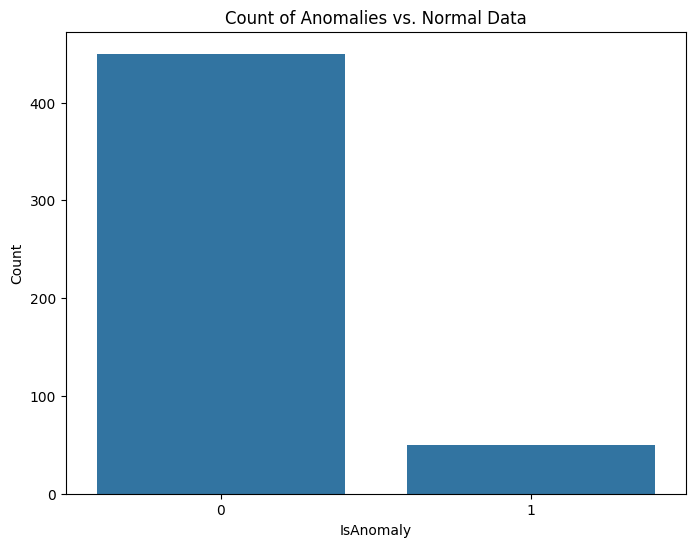

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='IsAnomaly')
plt.title('Count of Anomalies vs. Normal Data')
plt.xlabel('IsAnomaly')
plt.ylabel('Count')
plt.show()

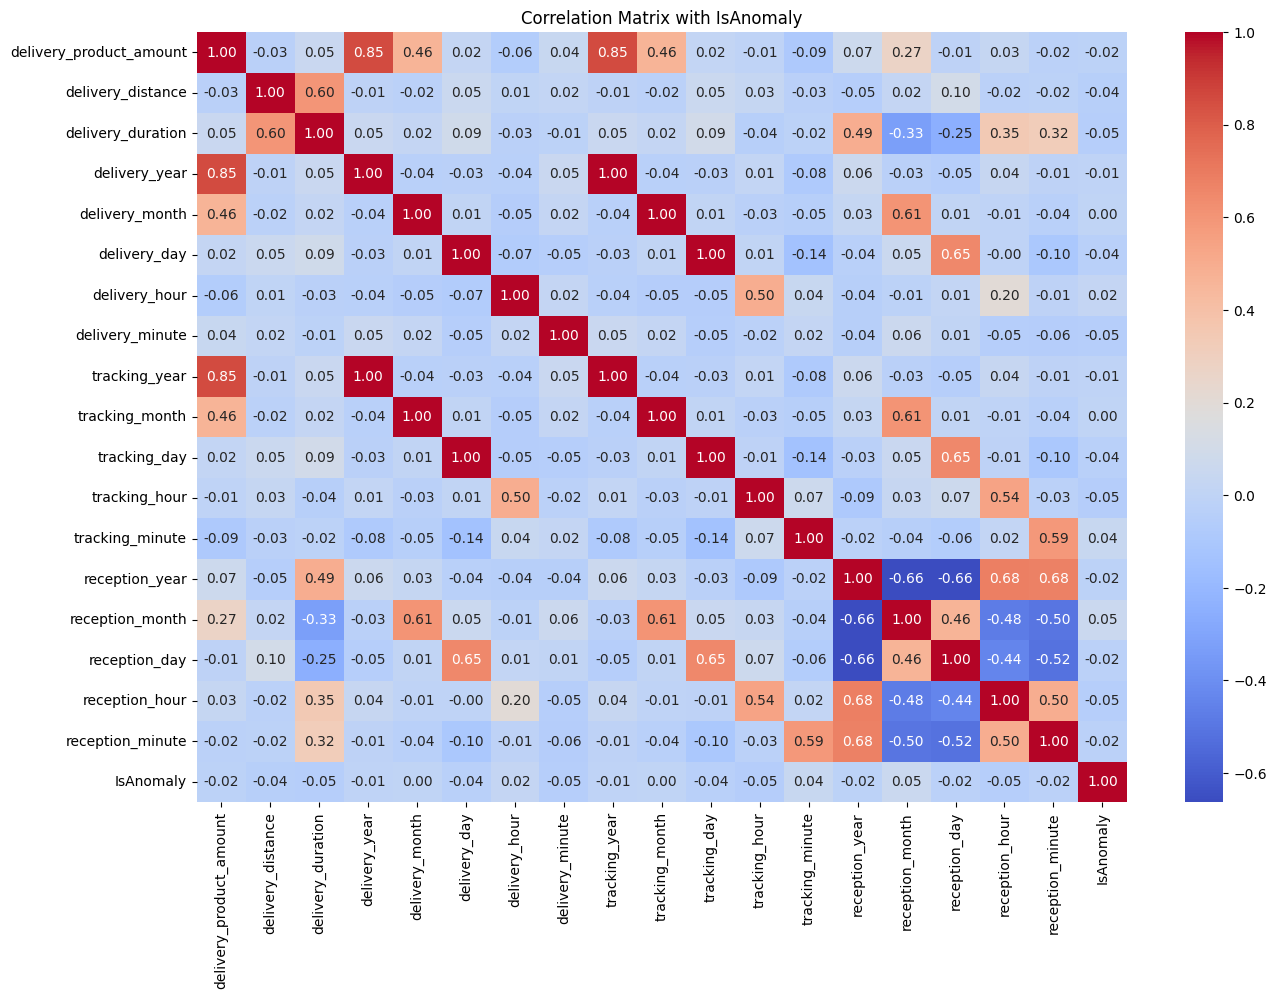

In [ ]:
import seaborn as sns
# Compute the correlation matrix
corr_matrix = data[numeric_features + ['IsAnomaly']].corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix with IsAnomaly')
plt.show()

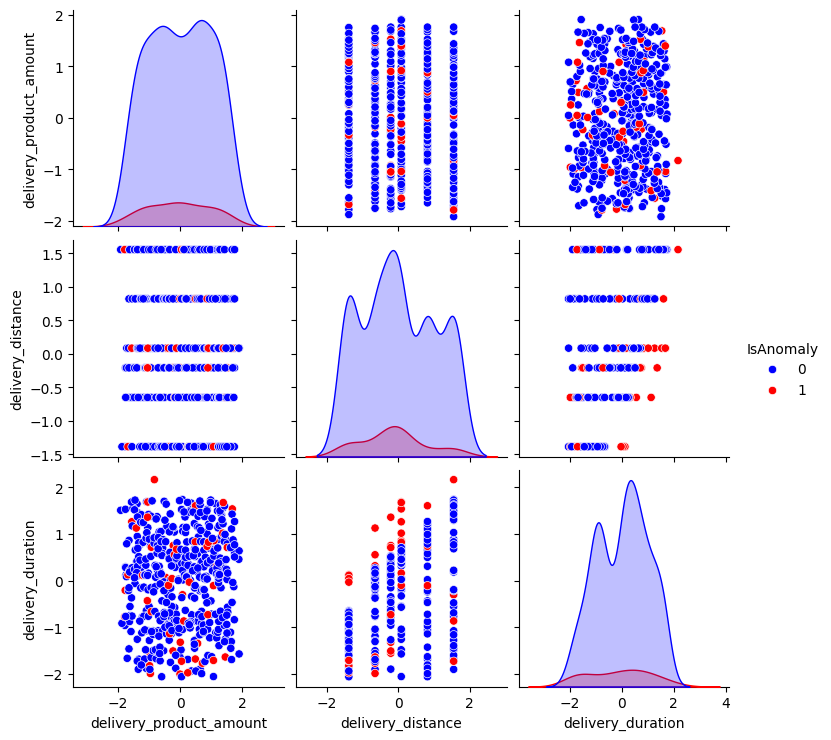

In [ ]:
# Select a subset of features for the pair plot
selected_features = ['delivery_product_amount', 'delivery_distance', 'delivery_duration', 'IsAnomaly']

# Convert categorical features to numeric for the pair plot
df_pairplot = data[selected_features].copy()
le = LabelEncoder()
df_pairplot['IsAnomaly'] = le.fit_transform(df_pairplot['IsAnomaly'])

# Plot the pair plot
sns.pairplot(df_pairplot, hue='IsAnomaly', palette={0: 'blue', 1: 'red'})
plt.show()

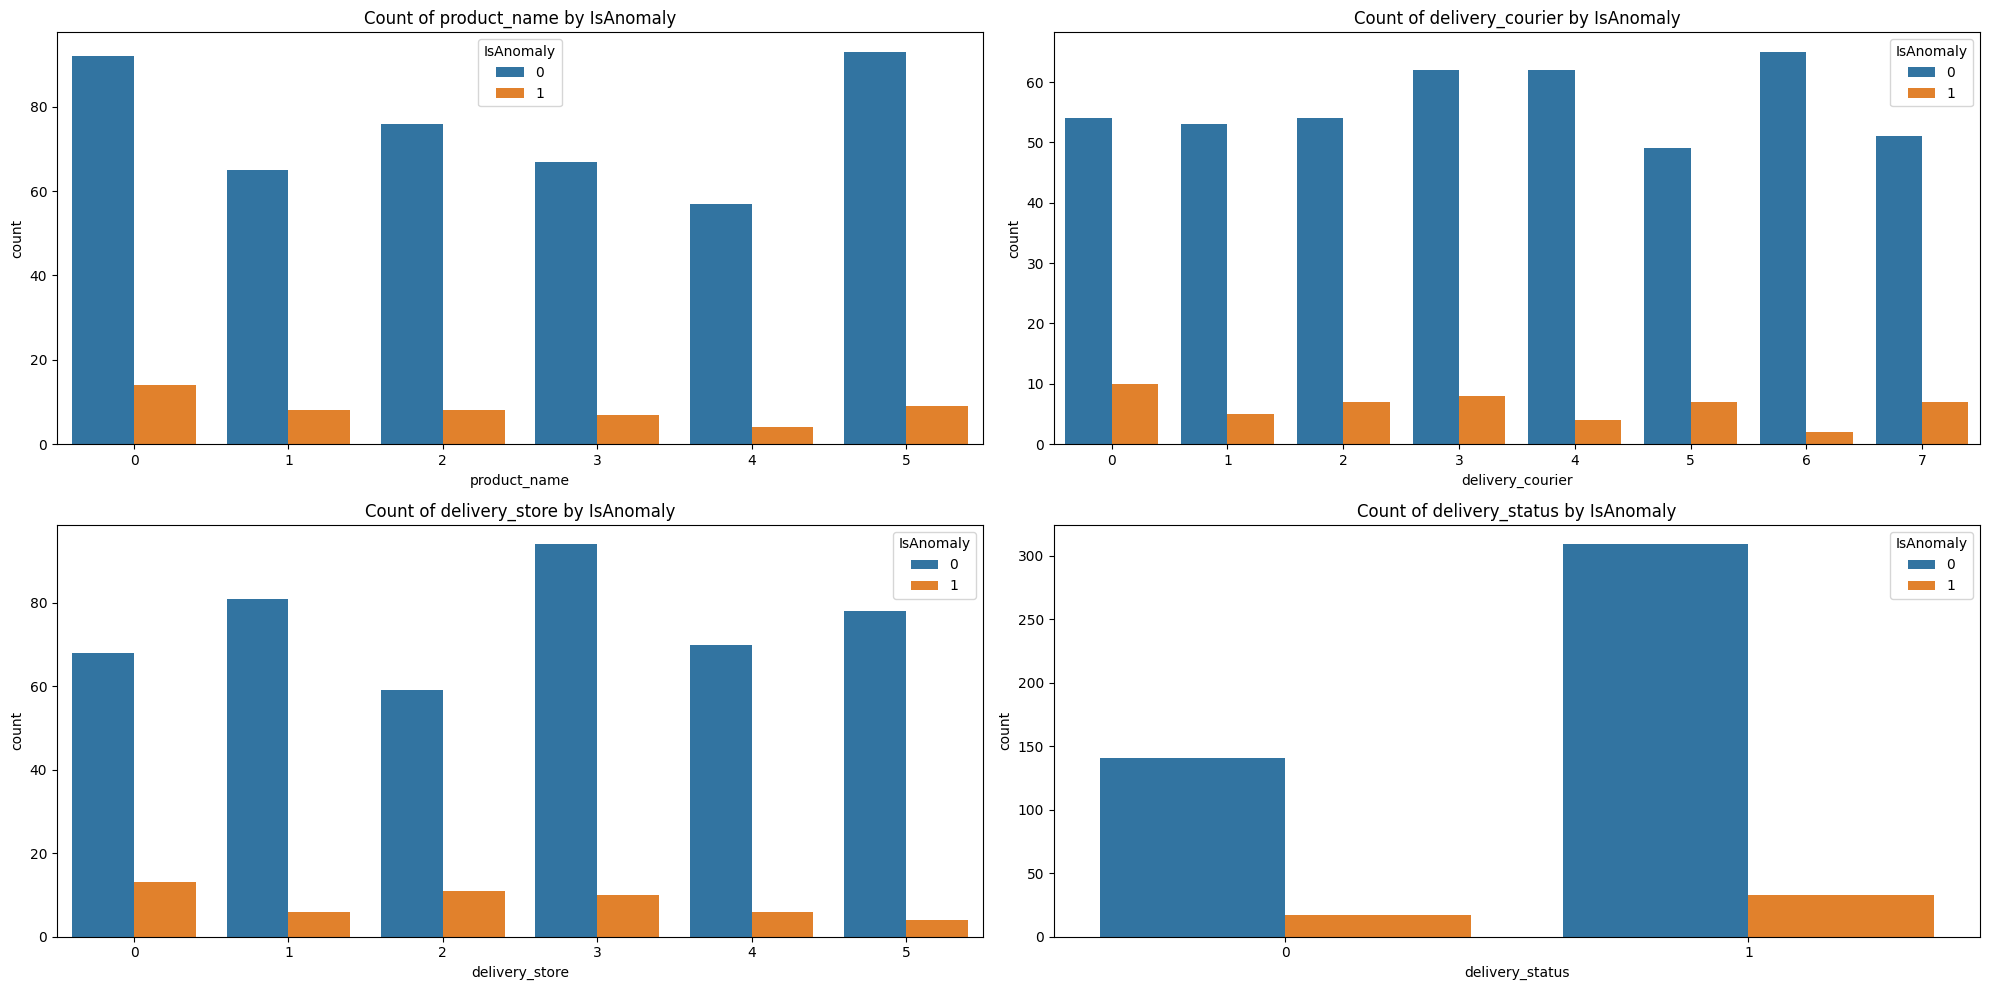

In [ ]:
# List of categorical features
categorical_features = ['product_name', 'delivery_courier', 'delivery_store', 'delivery_status']

# Plot count plots for categorical features
plt.figure(figsize=(20, 10))
for i, feature in enumerate(categorical_features):
    plt.subplot(2, 2, i + 1)
    sns.countplot(data=data, x=feature, hue='IsAnomaly')
    plt.title(f'Count of {feature} by IsAnomaly')
plt.legend(title='IsAnomaly')
plt.tight_layout()
plt.show()


# Splitting Data

In [ ]:
# The last element contains the labels
labels = data['IsAnomaly']

# The other data points are the electrocadriogram data
df = data.drop(['delivery_id', 'IsAnomaly'], axis=1)

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
df.shape

(500, 22)

# Build Model Autoencoder

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu')
        ])
    self.decoder = tf.keras.Sequential([
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(22, activation='sigmoid')
        ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(train_data, train_data,
                          epochs=500,
                          batch_size=250,
                          validation_data=(test_data, test_data))

Epoch 1/500
2/2 [==============================] - 3s 470ms/step - loss: 1.1271 - val_loss: 1.1188
Epoch 2/500
2/2 [==============================] - 0s 83ms/step - loss: 1.1248 - val_loss: 1.1167
Epoch 3/500
2/2 [==============================] - 0s 48ms/step - loss: 1.1227 - val_loss: 1.1146
Epoch 4/500
2/2 [==============================] - 0s 69ms/step - loss: 1.1205 - val_loss: 1.1123
Epoch 5/500
2/2 [==============================] - 0s 72ms/step - loss: 1.1179 - val_loss: 1.1097
Epoch 6/500
2/2 [==============================] - 0s 70ms/step - loss: 1.1151 - val_loss: 1.1065
Epoch 7/500
2/2 [==============================] - 0s 70ms/step - loss: 1.1116 - val_loss: 1.1027
Epoch 8/500
2/2 [==============================] - 0s 94ms/step - loss: 1.1074 - val_loss: 1.0981
Epoch 9/500
2/2 [==============================] - 0s 118ms/step - loss: 1.1021 - val_loss: 1.0924
Epoch 10/500
2/2 [==============================] - 0s 168ms/step - loss: 1.0958 - val_loss: 1.0858
Epoch 11/500
2/2

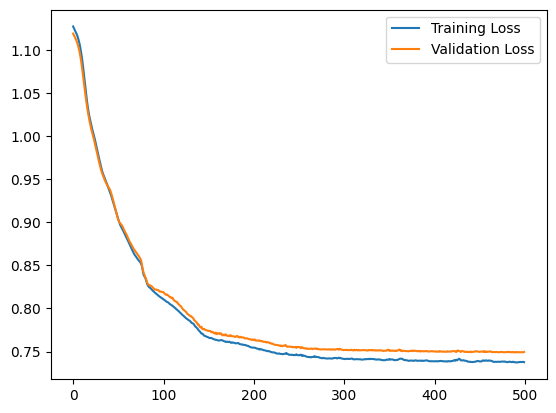

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
# Predict on test set to detect anomalies
reconstructions = autoencoder.predict(test_data)
reconstruction_errors = np.mean(np.abs(reconstructions - test_data), axis=1)

4/4 [==============================] - 0s 3ms/step


In [ ]:
# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)  # For example, 95th percentile
anomalies = reconstruction_errors > threshold

In [ ]:
# Get indices of anomalies
anomalous_indices = np.where(anomalies)[0]
print(anomalous_indices)

[10 13 50 68 99]


Detect anomalies

13/13 [==============================] - 0s 2ms/step


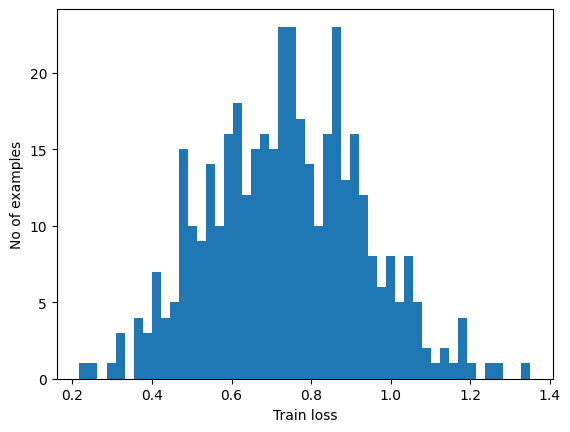

In [ ]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.9321708498225425


4/4 [==============================] - 0s 3ms/step


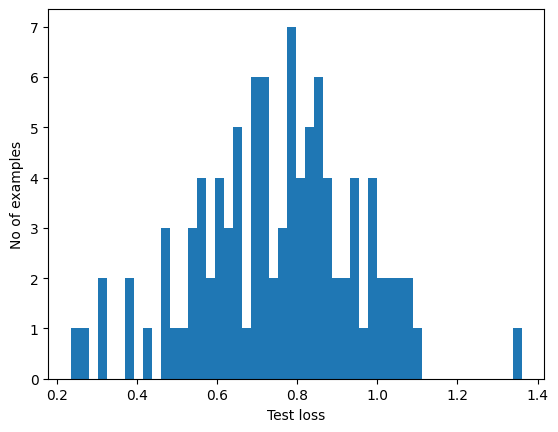

In [ ]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

# Saved weights model

In [ ]:
# Save the model in TensorFlow SavedModel format
import os

autoencoder.save_weights("autoencoder.h5")